# Introduction

The input data used for training in this project consists of two files. The first file, train_time_series.csv, 
contains the raw accelerometer data, which has been collected using the Beiwe research platform, and it has the 
following format:

timestamp, UTC time, accuracy, x, y, z

You can use the timestamp column as your time variable; you'll also need the last three columns, here labeled x, y, and z, which correspond to measurements of linear acceleration along each of the three orthogonal axes.

The second file, train_labels.csv, contains the activity labels, and you'll be using these labels to train your model. Different activities have been numbered with integers. We use the following encoding: 1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up. Because the accelerometers are sampled at high frequency, the labels in train_labels.csv are only provided for every 10th observation in train_time_series.csv.

# Activity Classification


The goal is to classify different physical activities as accurately as possible. We're provided with four csv files which contain the training data, training labels, testing data and testing label. As the labels are separated from training data, we need to combine the data sets as one to get a complete picture. 

The notebook is organized as follows: First, I will clean the data and do necessary modification to the features which will make it is easy to visualize the data. Then I will extract the data, and augment the given training data set for visualization and training. Once the complete data set is ready,  I will use the matplot library and seborn library to explore the data and visualize for a better understanding of the data.

In the susequent sections that will follow after exploratory data analysis, I will explore different algorithms available for training and testing for accuracy. In this section, I will use GridSearchCV to find best model suitable for our data set. Once I select the model, I'll proceed to find best parameters for that model which can give us more accurate answers. 

Once we're done with model and parameter selection, we'll train our model with the best parameters, and then using the model, we'll predict the activity for the data in test_time_series.csv file. Finally, I conclude the project with a conclusion section.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read the csv file using pandas library

time_series = pd.read_csv("train_time_series.csv")
train_labels = pd.read_csv("train_labels.csv")
test_labels = pd.read_csv("test_labels.csv")
test_time_series = pd.read_csv("test_time_series.csv")

# check the length of each data frame. This will be useful during training as we need equal length of predictor and 
# target variable.

print("Length train_time_series {} train_labels {}".format(len(time_series),len(train_labels)))
print("Length test_labels {} test_time_series {}".format(len(test_labels), len(test_time_series)))

time_series

Length train_time_series 3744 train_labels 375
Length test_labels 125 test_time_series 1250


,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
1,20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
2,20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
3,20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
4,20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450
...,...,...,...,...,...,...,...
3739,24325,1565110305638,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304
3740,24326,1565110305738,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213
3741,24327,1565110305838,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713
3742,24328,1565110305939,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805


In [2]:
# drop the columns which doesn't contain useful data
df1_test_labels = test_labels.drop(['label'], axis=1) # label column contains only Nan values. so remove it.
df1_time_series =time_series.drop(['accuracy'], axis=1) # accuracy values are unknown so will not be used in training


In [3]:
df1_time_series.head(10) # shows first 10 rows of this data frame

,Unnamed: 0,timestamp,UTC time,x,y,z
0,20586,1565109930787,2019-08-06T16:45:30.787,-0.006485,-0.934860,-0.069046
1,20587,1565109930887,2019-08-06T16:45:30.887,-0.066467,-1.015442,0.089554
2,20588,1565109930987,2019-08-06T16:45:30.987,-0.043488,-1.021255,0.178467
3,20589,1565109931087,2019-08-06T16:45:31.087,-0.053802,-0.987701,0.068985
4,20590,1565109931188,2019-08-06T16:45:31.188,-0.054031,-1.003616,0.126450
5,20591,1565109931288,2019-08-06T16:45:31.288,-0.010880,-0.967575,0.170898
6,20592,1565109931388,2019-08-06T16:45:31.388,0.052841,-0.982330,0.235565
7,20593,1565109931488,2019-08-06T16:45:31.488,0.032974,-1.053207,0.256714
8,20594,1565109931589,2019-08-06T16:45:31.589,-0.090424,-0.972794,0.356308
9,20595,1565109931689,2019-08-06T16:45:31.689,0.124268,-0.890533,0.223221


In [4]:
df1_time_series.info() # this shows the information about a data frame. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3744 non-null   int64  
 1   timestamp   3744 non-null   int64  
 2   UTC time    3744 non-null   object 
 3   x           3744 non-null   float64
 4   y           3744 non-null   float64
 5   z           3744 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 175.6+ KB


# Data cleaning

Now we clean the data and retain useful information, which we will use to train and test the model.
Data cleaning usually requires replacing/removing any 'NaN' or 'inf' values. Also, it is useful to change
the column names if they are not named properly. Here, I will remove the NaN values and also rename the first column which reads 'Unnamed: 0'. This name clearly is a bit odd. I will change it to 'user_id'. In this section, I will write two functions, one for data cleaning and the other for renaming of a column.

In [5]:
# clean data

def clean_data(df):
    """ This functions takes a data frame as input and then
    replaces the infinity with np.nan, which then drops the rows where the vale NaN occurs."""
    df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(axis=0)
    return df

def rename_column(df, old_column, new_column):
    """ This function renames a column
    input-1: data frame
    input-2: str (column name you want to change)
    input-3: str (new column name)"""
    df.rename(columns={old_column:new_column}, inplace=True)
    return df

df1_time_series = clean_data(time_series)
df1_train_labels = clean_data(train_labels)
df1_test_labels = clean_data(test_labels)
df1_test_time_series = clean_data(test_time_series)

# rename the first column.

df1_time_series = rename_column(df1_time_series, 'Unnamed: 0', 'user_id')
df1_test_time_series = rename_column(df1_test_time_series, 'Unnamed: 0', 'user_id')
df1_train_labels = rename_column(df1_train_labels, 'Unnamed: 0', 'user_id')
df1_train_labels.head()



,user_id,timestamp,UTC time,label
0,20589,1565109931087,2019-08-06T16:45:31.087,1
1,20599,1565109932090,2019-08-06T16:45:32.090,1
2,20609,1565109933092,2019-08-06T16:45:33.092,1
3,20619,1565109934094,2019-08-06T16:45:34.094,1
4,20629,1565109935097,2019-08-06T16:45:35.097,1


In [7]:
# In this step we'll drop any rows where we don't have any timestamp value (if any), i.e., timestamp = 0.

df1_time_series = df1_time_series[time_series['timestamp'] != 0]
df1_train_labels = df1_train_labels[train_labels['timestamp'] != 0]
df1_test_time_series = df1_test_time_series[test_time_series['timestamp'] != 0]


print(len(df1_train_labels))
df1_train_labels.head()
df1_time_series.head()

375


,user_id,timestamp,UTC time,accuracy,x,y,z
0,20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
1,20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
2,20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
3,20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
4,20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450


# Data Extraction for training

Now it is time to extract data for data exploration and training. We are provided train labels for only 375 data points. However, the "train_time_series.csv" contains 3744 data points. Also, "train_labels" does not contain the x, y, z accelerometer data. This means we have to exctract the x, y, z-accelerometer data from "train_time_series" data frame and combine it with the data from train_labels to get the complete data set for exploration and training. 

A quick look to the two data frames will reveal that the data in train_labels are actually every 10th data point from the "train_time_series" data frame. So, we extract these values and combine to get the complete data set with labels. For training and data exploration, I will use the data in 'df2'. However, for prediction, I will create another data set 'df3', and use it after I select the model and its parameters.

In [8]:
X0 = df1_time_series.iloc[3::10] # extracting every 10th row from the data frame df1_time_series, starting with the 3rd row.
X0.head()
df2 = X0.drop(['UTC time'], axis=1) # the time stamp data contains the time data which is not useful for our training.
                                    #So, we don't nee 'UTC time' data column

# After extracting every 10th row from time_series data frame, the index column also reads like 0, 10. 
# So, we need to change that to a continuous indices of integers, i.e., 1, 2, 3,... etc.


df2 = df2.rename(index={k:v for k,v in zip(df2.index, range(0,len(df2)))}) 
df2['label'] = df1_train_labels.label # complete the data set by creating a label column in the data frame X.

# Extract data and save it to df3 for model prediction.
# Here, we will extract every 10th row of the df1_test_time_series data, strating with the 9th row.
df3 = df1_test_time_series.iloc[9::10]
df3 = df3.rename(index={k:v for k,v in zip(df3.index, range(0,len(df3)))}) # rename the indices as a continuous set of  inteers, 1,2,3..etc.


# Exploratory data analysis

In this section, we explore the features of our data by visualising them through the seaborn library. First, we will plot the frequency of each labels.

<AxesSubplot:>

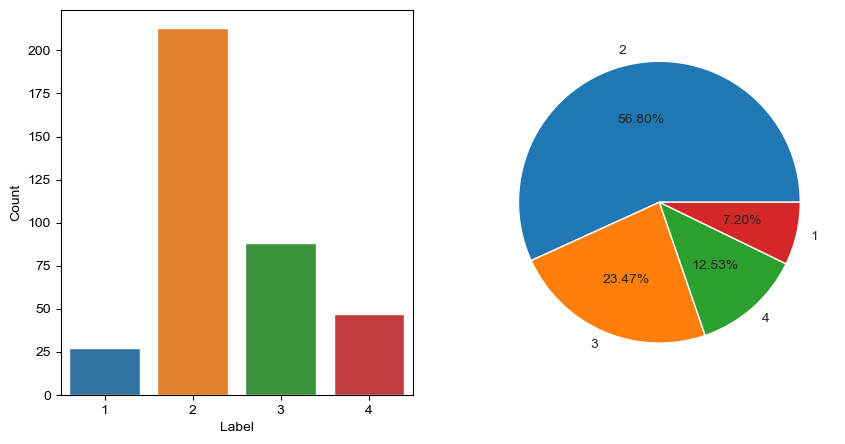

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,5))  # create a subplot for 2 figures (1 row, 2 columns)
sns.set_style('whitegrid') # set background as a white grid
sns.countplot(data = df2, ax = ax[0], x='label').set(xlabel='Label', ylabel='Count') # first plot
# This plots the count of each labels

df2['label'].value_counts().plot.pie(autopct='%1.2f%%', ax = ax[1], shadow=False, label="") # second plot.
# creats a pie chart which shows fraction each label occupies in the data set.


Here, 1 = standing, 2 = Walking, 3 = stairs down, 4 = stairs up.

The above plot shows the walking count is more than other activities and more than 50% of the data belong to category 2, i.e., walking. It is interesting to see that the walking count is less than standing count which means people prefer walking than simply standing. The plot also shows that walking upstais is less frequent than walking down the stairs. This is probably because it is more exhausting to walk upstairs than down stairs.

Next, we plot histograms for each x, y, z values. As can be seen from the figure below, the histogram plots for accelerometer data along axis roughly follows a normal distribution.

Text(0.5, 1.0, 'z')

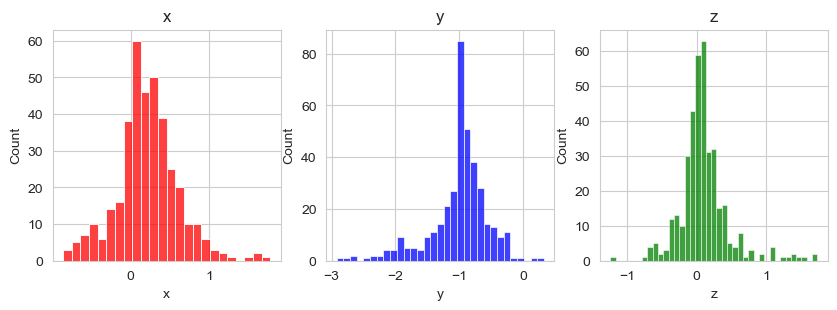

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(10,3)) # create a subplot for three figures in one row and three columns
sns.histplot(data=df2, x='x',  ax = ax[0], color='red').set_title('x')
sns.histplot(data=df2, x='y',  ax = ax[1], color='blue').set_title('y')
sns.histplot(data=df2, x='z',  ax = ax[2], color='green').set_title('z')

# Here, we plot histogram for x, y, z data of the accelerometer.

Text(0.5, 1.0, 'timestamp')

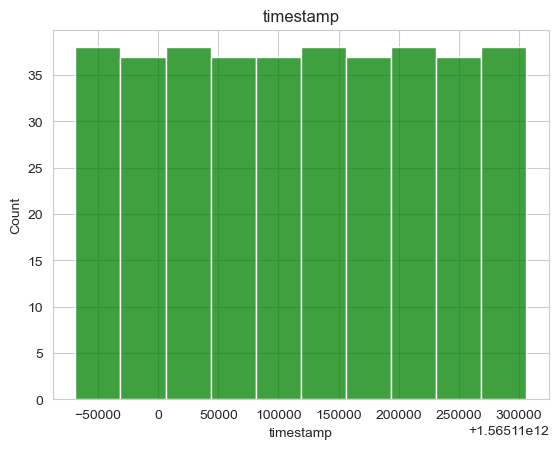

In [26]:
sns.histplot(data=df2, x='timestamp', color='green').set_title('timestamp')


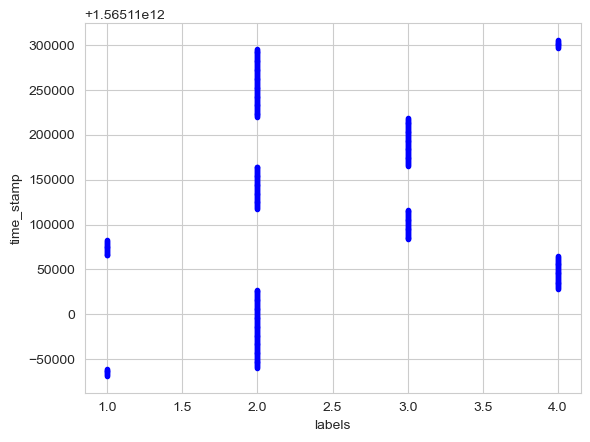

In [11]:
# Plotting time_stamp against labels. This will show clear separation of labels.

%matplotlib inline
plt.plot(df2.label, df2.timestamp, 'b.')
plt.xlabel('labels')
plt.ylabel('time_stamp')
plt.show()



The above plot between different activity and time stamp shows that there is no overlapping between the activities
at a given time interval. This shows that each event is independent of each other, which should be the case in a 
classification problem.

# Model Selection for training

As the problem is about predicting categorical variables, we will use a classification algorithm to train our model. There are many classifier models available, and a few of them were presented in this course itself. In the course, we used Logistic regression and Random forest classfier for our classification problems. We can also use Decision Tree classifier for our modeling. 

To decide which model performs better, we will use GridSearchCV to find the scores for each model and take the best performing model. The GridSearchCV performs cross validation on the data with different hyperparameters and stores the best score and the corresponding hyper parameter. In a k-fold cross validation, the program splits the data set into n/k test sets and n - n/k train sets, where n is the total number of data points and k < n.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import tree


In [64]:
# Define another data frame with predictor variables only.
# Then create another variable for the target value. i.e., label of the activity.
features = ['timestamp', 'x', 'y', 'z']
X = df2[features]
y = df2.label


In [65]:
# X['time_normal'] = X.timestamp.apply(lambda x: (x - X.timestamp.mean())/(X.timestamp.std()))
X.head()

,timestamp,x,y,z
0,1565109931087,-0.053802,-0.987701,0.068985
1,1565109932090,0.013718,-0.852371,-0.000870
2,1565109933092,0.145584,-1.007843,-0.036819
3,1565109934094,-0.099380,-1.209686,0.304489
4,1565109935097,0.082794,-1.001434,-0.025375


In [66]:
X0 = X.copy()

In [75]:
# Split the data into training and testing data. 
# Here, the test_size determines the number of data points to considered for testing.
# e.g. if test_size=0.2, then 20% of the data will be used for testing and rest 80% for training.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
# split = int(0.75*len(X))
# X_train = X0[0:split]
# y_train = y[0:split]
# X_test = X0[split:]
# y_test = y[split:]
X_train.head()

,timestamp,x,y,z
20,1565109951133,0.212891,-1.295456,-0.102692
90,1565110021294,0.195221,-1.140976,0.469421
141,1565110072503,0.079727,-1.002930,0.046844
224,1565110155694,0.235748,-0.963409,0.219940
250,1565110181754,0.386871,-1.080902,0.030136


In [19]:
y_train.shape

(262,)

In [79]:
# define a dictionary for GridSearchCV
# The dictionary contains model names as keys and then another dictionary as value, which contains
# the model and parameters for the corresponding model.
# Here, I will take a few parameters and look for the best model.

model_params = {"tree":{"model": DecisionTreeClassifier(random_state=0), 
                      "params": {"max_depth": list(range(1,5))}},
              "random_forest":{"model": RandomForestClassifier(random_state=0),
                               "params":{"n_estimators":[1,5,10,20,50,60,70,80,1000]}},
              "logistic_regression":{"model":LogisticRegression(solver = 'liblinear',multi_class='auto',random_state=0),
                                    "params":{"C":[1,5,10]}},

               }

scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score=False)
    clf.fit(X,y)
    scores.append({
        'model':model_name,
        'best_score': clf.best_score_,
        'best_param': clf.best_params_
    })
    
df0 = pd.DataFrame(scores) # convert the scores dictionary into a data frame

print(df0) # print the values to get the scores for various models

                 model  best_score            best_param
0                 tree    0.568000      {'max_depth': 1}
1        random_forest    0.570667  {'n_estimators': 50}
2  logistic_regression    0.568000              {'C': 1}


It is clear from the above data frame that Random Forest Classifier performs better than decision tree and logistic regression. So, I will choose random forest classifier to train and test my model. 

# Finding the best parameter for training

Now lets find out the value of n_estimators that gives us highest accuracy score. To acheive this we train the model for different n_estimators parameter and append each score to a list and then plot the scores against the n_estimators values.

1


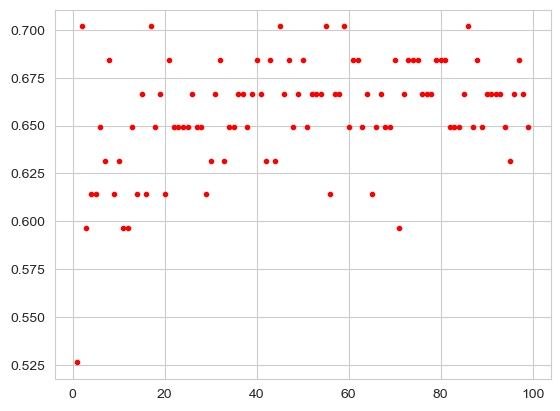

In [80]:
lst1 = []
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
for i in range(1,100):
    model1 = RandomForestClassifier(n_estimators=i) #create an object instance of RandomForestClassifier
    model1.fit(X_train,y_train)  # train the model
    lst1.append(model1.score(X_test, y_test)) # save the model score.

lst0 = [i for i in range(1,100)]
plt.plot(lst0, lst1, 'r.')
print(lst1.index(max(lst1)));

Here, we get the maximum score for n_estimators = 8, with random_state = 0. So, we will use this to train our model
and the subsequently use the model to predict for the test_labels given to us.

In [70]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# create an object instance of RandomForestClassifier, with parameter n_estimator=80.
rfc = RandomForestClassifier(n_estimators=10, random_state=0)

rfc.fit(X_train,y_train)  # now train the model using X_train and y_train data
rfc.score(X_test, y_test) # check the model score 


0.5638297872340425

In [72]:
from sklearn.metrics import accuracy_score

y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)

0.5638297872340425

In [73]:
# Extract test data for prediction from df3.
X_pred_data = df3.drop(['user_id', 'UTC time', 'accuracy'], axis=1)
X_pred_data.head() # show first 5 rows

# We want to predict values for this data set

,timestamp,x,y,z
0,1565110307041,0.098282,-0.833771,0.118042
1,1565110308043,0.348465,-0.946701,-0.051041
2,1565110309046,0.377335,-0.849243,-0.026474
3,1565110310048,0.110077,-0.520325,0.312714
4,1565110311050,0.283478,-0.892548,-0.085876


In [74]:
# Prediction from the model

new_pred = rfc.predict(X_pred_data)
print("model predicts {}% of the test data belong to category {}".format(100*np.count_nonzero(new_pred==2)/ len(new_pred),2))
print("model predicts {}% of the test data belong to category {}".format(100*np.count_nonzero(new_pred==4)/ len(new_pred),2))

print(new_pred)

model predicts 68.0% of the test data belong to category 2
model predicts 0.0% of the test data belong to category 2
[3 2 2 3 2 2 3 3 2 2 2 3 3 2 2 2 2 3 2 3 2 2 3 2 2 3 2 2 2 3 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2 3 2 2 2 2 2 2 3 3 3 3 2 3 3 2 3
 2 2 3 2 3 2 2 3 2 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2 2 3 2 2 3 3 2
 2 2 2 3 2 2 3 3 2 2 2 2 2 2]


# Results

The RandomForestClassifier model used for this model, has a 72% accuracy. Using this model, I predicted the activity labels for the given test data. The model classifies 96% of the data as label 2 and rest of the 4% as label 4. This should not be surprising as in the original data set 56% of the data belonged to activity label 2. So, given that the whole data set (training + testing) is a well mixed data set, the probability that a given data point belonging to category 2 is more than 50%. It is also interesting to notice that the prediction does not contain any category belonging to label 3 or 1.

On the course website, the classification accuracy for this prediction, however, shows an accuracy of 34%. This probably means that the model has low bias and high variance, i.e., it has high train accuracy and low test accuracy. 


In [21]:
pred_file = pd.DataFrame(new_pred, columns=['prediction']) # convert the predicted file to a data frame
pred_file.to_csv("predictions.csv")  # save the data frame to a csv file.

# Conclusion

In this project, we were given the accelerometer data and the task was to classify activities from the timestamp and accelerometer data. For this classification problem, I conducted a grid search method to find the best model to train and predict the correct values. The grid search was performed on four different models, namely, LogisticRegression, RandomForestClassifier, and Decission Tree Classifier with different hyper parameters. I found that RandomForestClassifier performs better than others with the hyper prameter n_estimator=80.

I used RandomForestClassifier to train my model and predict the labels for the given test data file. 
The model is 72% accurate. I used this model to predict the given test cases for which the label data was not provided. Interestingly, the model classifies more than 95% of the test data as activity 2, i.e., walking. This should not be surprising as more than 56% of the data belong to this category in the training data set.

Modeling the activity classification was challenging, and the accuracy was also poor. I tuned the hyperparameter n_estimator and the training sample size to improve the accuracy score from 55% to 72%. However, the testing prediction on the course website shows a accuracy of 34% for the predicted values, which differs significantly from the score I got in my model. I believe, the model score can be improved by adding more data to the data set or doing necessary feature engineering.

